# Interactive Examples on Project Aria Tools

### Notebook stuck?
Note that because of Jupyter issues, sometimes the code may stuck at visualization. We recommend **restart the kernels** and try again to see if the issue is resolved.

In [9]:
# Specifics for Google Colab
google_colab_env = 'google.colab' in str(get_ipython())
if google_colab_env:
    print("Running from Google Colab, installing projectaria_tools and getting sample data")
    !pip install projectaria-tools
    !curl -O -J -L "https://github.com/facebookresearch/projectaria_tools/raw/main/data/mps_sample/sample.vrs"
    vrsfile = "sample.vrs"
else:
    print("Using a pre-existing projectaria_tool github repository")
    vrsfile = "../../data/mps_sample/sample.vrs"

Running from Google Colab, installing projectaria_tools and getting sample data
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 75.1M  100 75.1M    0     0  48.7M      0  0:00:01  0:00:01 --:--:--  224M


In [10]:
from projectaria_tools.core import data_provider, calibration
from projectaria_tools.core.sensor_data import TimeDomain, TimeQueryOptions
from projectaria_tools.core.stream_id import RecordableTypeId, StreamId
import numpy as np
from matplotlib import pyplot as plt

## Create data provider

In [11]:
print("Creating data provider from {vrsfile}")
provider = data_provider.create_vrs_data_provider(vrsfile)
if not provider:
    print("Invalid vrs data provider")

Creating data provider from {vrsfile}


# Summarize a VRS using thumbnails

Goals:
- Summarize a VRS using 10 image side by side

Key learnings:
- Image streams are identified with a Unique Identifier: stream_id
- PIL images can be created from Numpy array

In [13]:
from PIL import Image
from tqdm import tqdm

rgb_stream_id = StreamId("214-1")


# Retrieve image size for the RGB stream
time_domain = TimeDomain.DEVICE_TIME  # query data based on host time
option = TimeQueryOptions.CLOSEST # get data whose time [in TimeDomain] is CLOSEST to query time

# Retrieve Start and End time for the given Sensor Stream Id
start_time = provider.get_first_time_ns(rgb_stream_id, time_domain)
end_time = provider.get_last_time_ns(rgb_stream_id, time_domain)

image_config = provider.get_image_configuration(rgb_stream_id)
width = image_config.image_width
height = image_config.image_height

# sample_count = 10
# resize_ratio = 10
# thumbnail = newImage = Image.new(
#     "RGB", (int(width * sample_count / resize_ratio), int(height / resize_ratio))
# )
# current_width = 0


# # Samples 10 timestamps
# sample_timestamps = np.linspace(start_time, end_time, sample_count)
# for sample in tqdm(sample_timestamps):
#     image_tuple = provider.get_image_data_by_time_ns(rgb_stream_id, int(sample), time_domain, option)
#     image_array = image_tuple[0].to_numpy_array()
#     image = Image.fromarray(image_array)
#     new_size = (
#         int(image.size[0] / resize_ratio),
#         int(image.size[1] / resize_ratio),
#     )
#     image = image.resize(new_size).rotate(-90)
#     thumbnail.paste(image, (current_width, 0))
#     current_width = int(current_width + width / resize_ratio)

# from IPython.display import Image
# display(thumbnail)

## Pytorch Data Loaders Example (RGB)

In [14]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

class RGBDataset(Dataset):
    def __init__(self, start_time, end_time, sample_count, transform=None):
        self.timestamps = np.linspace(start_time, end_time, sample_count)
        self.rgb_stream_id = StreamId("214-1")
        self.time_domain = TimeDomain.DEVICE_TIME
        self.option = TimeQueryOptions.CLOSEST
        self.transform = transform

    def __len__(self):
        return len(self.timestamps)

    def __getitem__(self, idx):
        timestamp = self.timestamps[idx]
        image_tuple = provider.get_image_data_by_time_ns(self.rgb_stream_id, int(timestamp), self.time_domain, self.option)
        image_array = image_tuple[0].to_numpy_array()
        image = Image.fromarray(image_array).rotate(-90)
        if self.transform:
          image = self.transform(image)
        return timestamp, image

In [8]:
# crop_size = 336
# val_transform = transforms.Compose([
#     transforms.Resize(crop_size),
#     transforms.ToTensor(),
#   ])

# rgb_dataset = RGBDataset(start_time, end_time, sample_count, transform=val_transform)
# frame_dataloader = DataLoader(rgb_dataset, batch_size=2, shuffle=False)

# # Create an iterator from the dataloader
# data_iter = iter(frame_dataloader)

# # Get the next batch of data
# timestamp, image = next(data_iter)

In [18]:
class RGBSnippetDataset(Dataset):
    def __init__(self, start_time: float, end_time: float, snippet_dur_sec: int, frames_per_snippet: int, transform=None):
        self.start_time = start_time
        self.end_time = end_time
        self.snippet_dur = snippet_dur_sec * 1000000000 # duration of a snippet in nano seconds
        self.frames_per_snippet = frames_per_snippet # number of frames per snippet
        self.stride_ns = int(self.snippet_dur//frames_per_snippet)
        self.num_snippets = int((end_time - start_time) // self.snippet_dur)
        self.snippet_starts = np.arange(start_time, start_time + self.snippet_dur * self.num_snippets, self.snippet_dur)

        # Precompute all required timestamps for each snippet
        self.all_frame_timestamps = [np.arange(snippet_start, snippet_start + self.snippet_dur, self.stride_ns) for snippet_start in self.snippet_starts]

        self.rgb_stream_id = rgb_stream_id
        self.time_domain = time_domain
        self.option = option
        self.transform = transform

    def __len__(self):
        return self.num_snippets

    def __getitem__(self, idx):
        frame_timestamps = self.all_frame_timestamps[idx]

        image_list = []
        for timestamp in frame_timestamps:
            image_tuple = provider.get_image_data_by_time_ns(self.rgb_stream_id, int(timestamp), self.time_domain, self.option)
            image_array = image_tuple[0].to_numpy_array()
            image_list.append(image_array)

        frames = [torch.tensor(frame, dtype=torch.float32) for frame in image_list]
        frames = torch.stack(frames, dim=0)

        if self.transform:
          frames = self.transform(frames)

        snippet_start = self.snippet_starts[idx]
        snippet_end = snippet_start + self.snippet_dur

        return frames, snippet_start, snippet_end

In [25]:
import torchvision.transforms as transforms
import torchvision.transforms._transforms_video as transforms_video
import torch.nn as nn

class Permute(nn.Module):
    """
    Permutation as an op
    """
    def __init__(self, ordering):
        super().__init__()
        self.ordering = ordering

    def forward(self, frames):
        """
        Args:
            frames in some ordering, by default (C, T, H, W)
        Returns:
            frames in the ordering that was specified
        """
        return frames.permute(self.ordering)

crop_size = 224
val_transform = transforms.Compose([
    Permute([3, 0, 1, 2]),  # T H W C -> C T H W
    transforms.Resize(crop_size),
    transforms.CenterCrop(crop_size),
    transforms_video.NormalizeVideo(mean=[108.3272985, 116.7460125, 104.09373615000001], std=[68.5005327, 66.6321579, 70.32316305]),
])

In [26]:
rgb_snippet_dataset = RGBSnippetDataset(start_time, end_time, snippet_dur_sec = 2, frames_per_snippet=4, transform=val_transform)
snippet_dataloader = DataLoader(rgb_snippet_dataset, batch_size=1, shuffle=False)

In [27]:
# Get the next batch of data
frames, st_ns, ed_ns = next(iter(snippet_dataloader))

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [28]:
frames.size()

torch.Size([1, 3, 4, 224, 224])

## Run LaViLa auto-narration model

In [37]:
# install LaViLa as dependency
!pip install git+https://github.com/zhaoyang-lv/LaViLa

  Cloning https://github.com/zhaoyang-lv/LaViLa to /tmp/pip-req-build-3dm3jipx
  Running command git clone --filter=blob:none --quiet https://github.com/zhaoyang-lv/LaViLa /tmp/pip-req-build-3dm3jipx
  Resolved https://github.com/zhaoyang-lv/LaViLa to commit e143d74bf1e15f97ac47883b4316232c186d89a1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 64.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 13.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 88.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 5.1 MB/s eta 0:00:00
 

In [2]:
import os
import urllib.request
from collections import OrderedDict
import torch

from lavila.models.models import VCLM_OPENAI_TIMESFORMER_LARGE_336PX_GPT2_XL, VCLM_OPENAI_TIMESFORMER_BASE_GPT2
from lavila.models.tokenizer import MyGPT2Tokenizer

DEFAULT_CHECKPOINT = 'vclm_openai_timesformer_base_gpt2_base.pt_ego4d.jobid_319630.ep_0002.md5sum_68a71f.pth'
# DEFAULT_CHECKPOINT = 'vclm_openai_timesformer_large_336px_gpt2_xl.pt_ego4d.jobid_246897.ep_0003.md5sum_443263.pth'

def load_models_and_transforms(num_frames=4, ckpt_name=DEFAULT_CHECKPOINT, device='cpu'):
    ckpt_path = os.path.join('lavila/modelzoo/', ckpt_name)
    print(f"ckpt_path: {os.path.abspath(ckpt_path)}")
    os.makedirs('lavila/modelzoo/', exist_ok=True)
    if not os.path.exists(ckpt_path):
        print('downloading model to {}'.format(ckpt_path))
        urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/lavila/checkpoints/narrator/{}'.format(ckpt_name), ckpt_path)
    ckpt = torch.load(ckpt_path, map_location='cpu')
    state_dict = OrderedDict()
    for k, v in ckpt['state_dict'].items():
        state_dict[k.replace('module.', '')] = v

    # instantiate the model, and load the pre-trained weights
    # model = VCLM_OPENAI_TIMESFORMER_LARGE_336PX_GPT2_XL(
    model = VCLM_OPENAI_TIMESFORMER_BASE_GPT2(
        text_use_cls_token=False,
        project_embed_dim=256,
        gated_xattn=True,
        timesformer_gated_xattn=False,
        freeze_lm_vclm=False,      # we use model.eval() anyway
        freeze_visual_vclm=False,  # we use model.eval() anyway
        num_frames=num_frames,
        drop_path_rate=0.
    )
    model.load_state_dict(state_dict, strict=True)

    device_type_str = device.type if isinstance(device, torch.device) else device
    if device_type_str != 'cpu':
        model = model.to(device)
    model.eval()

    tokenizer = MyGPT2Tokenizer('gpt2', add_bos=True)
    #tokenizer = MyGPT2Tokenizer('gpt2-xl', add_bos=True)

    return model, tokenizer

In [3]:
model, tokenizer = load_models_and_transforms(num_frames=4)

ckpt_path: /content/lavila/modelzoo/vclm_openai_timesformer_base_gpt2_base.pt_ego4d.jobid_319630.ep_0002.md5sum_68a71f.pth
downloading model to lavila/modelzoo/vclm_openai_timesformer_base_gpt2_base.pt_ego4d.jobid_319630.ep_0002.md5sum_68a71f.pth
######USING ATTENTION STYLE:  frozen-in-time


100%|███████████████████████████████████████| 335M/335M [00:03<00:00, 88.5MiB/s]


=> Loading CLIP (ViT-B/16) weights
_IncompatibleKeys(missing_keys=['temporal_embed', 'blocks.0.timeattn.qkv.weight', 'blocks.0.timeattn.qkv.bias', 'blocks.0.timeattn.proj.weight', 'blocks.0.timeattn.proj.bias', 'blocks.0.norm3.weight', 'blocks.0.norm3.bias', 'blocks.1.timeattn.qkv.weight', 'blocks.1.timeattn.qkv.bias', 'blocks.1.timeattn.proj.weight', 'blocks.1.timeattn.proj.bias', 'blocks.1.norm3.weight', 'blocks.1.norm3.bias', 'blocks.2.timeattn.qkv.weight', 'blocks.2.timeattn.qkv.bias', 'blocks.2.timeattn.proj.weight', 'blocks.2.timeattn.proj.bias', 'blocks.2.norm3.weight', 'blocks.2.norm3.bias', 'blocks.3.timeattn.qkv.weight', 'blocks.3.timeattn.qkv.bias', 'blocks.3.timeattn.proj.weight', 'blocks.3.timeattn.proj.bias', 'blocks.3.norm3.weight', 'blocks.3.norm3.bias', 'blocks.4.timeattn.qkv.weight', 'blocks.4.timeattn.qkv.bias', 'blocks.4.timeattn.proj.weight', 'blocks.4.timeattn.proj.bias', 'blocks.4.norm3.weight', 'blocks.4.norm3.bias', 'blocks.5.timeattn.qkv.weight', 'blocks.5.tim

Loading LM from pretrained weights..
=> Initialize MyGPT2Tokenizer (gpt2)


In [30]:
with torch.no_grad():
  image_features = model.encode_image(frames)
  generated_text_ids, ppls = model.generate(
      image_features,
      tokenizer,
      target=None,  # free-form generation
      max_text_length=77,
      top_k=None,
      top_p=0.95,   # nucleus sampling
      num_return_sequences=4,  # number of candidates: 10
      temperature=0.7,
      early_stopping=True,
  )

# Obtain mapping between stream_id and sensor label
Goals:
- In a vrs file, each sensor data is identitied through stream_id
- Learn mapping between stream_id and label for each sensor

Key learnings:
- VRS is using Unique Identifier for each stream called stream_id.
- For each sensor data, it is attached with a stream_id, which contains two parts [RecordableTypeId, InstanceId].
- To get the actual readable name of each sensor,
we can use `get_label_from_stream_id` vise versa `get_stream_id_from_label`

In [6]:
streams = provider.get_all_streams()
for stream_id in streams:
    label = provider.get_label_from_stream_id(stream_id)
    print(
        f"stream_id: [{stream_id}] convert to label: [{label}] and back: [{provider.get_stream_id_from_label(label)}]"
    )

stream_id: [211-1] convert to label: [camera-et] and back: [211-1]
stream_id: [214-1] convert to label: [camera-rgb] and back: [214-1]
stream_id: [231-1] convert to label: [mic] and back: [231-1]
stream_id: [247-1] convert to label: [baro0] and back: [247-1]
stream_id: [281-1] convert to label: [gps] and back: [281-1]
stream_id: [282-1] convert to label: [wps] and back: [282-1]
stream_id: [283-1] convert to label: [bluetooth] and back: [283-1]
stream_id: [1201-1] convert to label: [camera-slam-left] and back: [1201-1]
stream_id: [1201-2] convert to label: [camera-slam-right] and back: [1201-2]
stream_id: [1202-1] convert to label: [imu-right] and back: [1202-1]
stream_id: [1202-2] convert to label: [imu-left] and back: [1202-2]
stream_id: [1203-1] convert to label: [mag0] and back: [1203-1]


# Get sensor data in a sequence based on data capture time
Goal:
- Obtain sensor data sequentially based on timestamp

Key learnings
- Default option activates all sensors and playback the entire dataset from vrs
- Setup option to only activate certain streams, truncate start/end time, and sample rate
- Obtain data from different sensor types
- `TimeDomain` are separated into four categories: `RECORD_TIME`, `DEVICE_TIME`, `HOST_TIME`, `TIME_CODE`

### Step 1: obtain default options that provides the whole dataset from VRS
* activates all sensor streams
* No truncation for first/last timestamp
* Subsample rate = 1 (do not skip any data per sensor)

In [7]:
options = (
    provider.get_default_deliver_queued_options()
)  # default options activates all streams

### Step 2: set prefered deliver options
* truncate first/last time: `set_truncate_first_device_time_ns/set_truncate_last_device_time_ns()`
* subselect sensor streams to play: `activate_stream(stream_id)`
* skip sensor data : `set_subsample_rate(stream_id, rate)`

In [8]:
options.set_truncate_first_device_time_ns(int(1e8))  # 0.1 secs after vrs first timestamp
options.set_truncate_last_device_time_ns(int(1e9))  # 1 sec before vrs last timestamp

# deactivate all sensors
options.deactivate_stream_all()
# activate only a subset of sensors
slam_stream_ids = options.get_stream_ids(RecordableTypeId.SLAM_CAMERA_DATA)
imu_stream_ids = options.get_stream_ids(RecordableTypeId.SLAM_IMU_DATA)

for stream_id in slam_stream_ids:
    options.activate_stream(stream_id)  # activate slam cameras
    options.set_subsample_rate(stream_id, 1)  # sample every data for each slam camera

for stream_id in imu_stream_ids:
    options.activate_stream(stream_id)  # activate imus
    options.set_subsample_rate(stream_id, 10)  # sample every 10th data for each imu

### Step 3: create iterator to deliver data
`TimeDomain` contains the following
* `RECORD_TIME`: timestamp stored in vrs index, fast to access, but not guaranteed which time domain
* `DEVICE_TIME`: capture time in device's timedomain, accurate
* `HOST_TIME`: arrival time in host computer's timedomain, may not be accurate
* `TIME_CODE`: capture in TimeSync server's timedomain


In [9]:
iterator = provider.deliver_queued_sensor_data(options)
for sensor_data in iterator:
    label = provider.get_label_from_stream_id(sensor_data.stream_id())
    sensor_type = sensor_data.sensor_data_type()
    device_timestamp = sensor_data.get_time_ns(TimeDomain.DEVICE_TIME)
    host_timestamp = sensor_data.get_time_ns(TimeDomain.HOST_TIME)
    timecode_timestamp = sensor_data.get_time_ns(TimeDomain.TIME_CODE)
    print(
        f"""obtain data from {label} of type {sensor_type} with \n
        DEVICE_TIME: {device_timestamp} nanoseconds \n
        HOST_TIME: {host_timestamp} nanoseconds \n
        """
    )

Streaming output truncated to the last 5000 lines.

        
obtain data from imu-left of type SensorDataType.IMU with 

        DEVICE_TIME: 156147808150 nanoseconds 

        HOST_TIME: 156156320408 nanoseconds 

        
obtain data from imu-right of type SensorDataType.IMU with 

        DEVICE_TIME: 156153250687 nanoseconds 

        HOST_TIME: 156159983064 nanoseconds 

        
obtain data from imu-left of type SensorDataType.IMU with 

        DEVICE_TIME: 156160417337 nanoseconds 

        HOST_TIME: 156165343793 nanoseconds 

        
obtain data from imu-right of type SensorDataType.IMU with 

        DEVICE_TIME: 156163243375 nanoseconds 

        HOST_TIME: 156169088324 nanoseconds 

        
obtain data from imu-left of type SensorDataType.IMU with 

        DEVICE_TIME: 156173026525 nanoseconds 

        HOST_TIME: 156177945043 nanoseconds 

        
obtain data from imu-right of type SensorDataType.IMU with 

        DEVICE_TIME: 156173236187 nanoseconds 

        HOST_

# Random access data
Goal
- Access data from a stream randomly using a data index or a timestamp

Key learnings
- Sensor data can be obtained through index within the range of [0, number of data for this stream_id)

  - `get_sensor_data_by_index(stream_id, index)`
  - `get_image_data_by_index(stream_id, index)`
  - Access other sensor data by index interface is available in core/python/VrsDataProviderPyBind.h
  
- `TimeQueryOptions` has three options: `TimeQueryOptions.BEFORE`, `TimeQueryOptions.AFTER`, `TimeQueryOptions.CLOSEST`
- Query through index will provide the exact data vs query through a timestamp that is not exact, data nearby will be omitted base on `TimeQueryOptions`

In [10]:
sensor_name = "camera-slam-right"
sensor_stream_id = provider.get_stream_id_from_label(sensor_name)

# get all image data by index
num_data = provider.get_num_data(sensor_stream_id)

for index in range(0, num_data):
    image_data = provider.get_image_data_by_index(sensor_stream_id, index)
    print(
        f"Get image: {index} with timestamp {image_data[1].capture_timestamp_ns}"
    )

Get image: 0 with timestamp 148502610950
Get image: 1 with timestamp 148602610950
Get image: 2 with timestamp 148702610950
Get image: 3 with timestamp 148802610950
Get image: 4 with timestamp 148902610950
Get image: 5 with timestamp 149002610925
Get image: 6 with timestamp 149102610925
Get image: 7 with timestamp 149202610925
Get image: 8 with timestamp 149302610925
Get image: 9 with timestamp 149402610925
Get image: 10 with timestamp 149502610925
Get image: 11 with timestamp 149602610925
Get image: 12 with timestamp 149702610925
Get image: 13 with timestamp 149802610925
Get image: 14 with timestamp 149902610925
Get image: 15 with timestamp 150002610950
Get image: 16 with timestamp 150102610925
Get image: 17 with timestamp 150202610937
Get image: 18 with timestamp 150302610925
Get image: 19 with timestamp 150402610925
Get image: 20 with timestamp 150502610950
Get image: 21 with timestamp 150602610950
Get image: 22 with timestamp 150702610950
Get image: 23 with timestamp 150802610950
Ge

### Sensor data can be obtained by timestamp (nanoseconds)
* Get stream time range `get_first_time_ns` and `get_last_time_ns`
* Specify timedomain: `TimeDomain.DEVICE_TIME` (default)
* Query data by queryTime
  * `TimeQueryOptions.BEFORE` (default): sensor_dataTime <= queryTime
  * `TimeQueryOptions.AFTER` : sensor_dataTime >= queryTime
  * `TimeQueryOptions.CLOSEST` : sensor_dataTime closest to queryTime

In [11]:
time_domain = TimeDomain.DEVICE_TIME  # query data based on DEVICE_TIME
option = TimeQueryOptions.CLOSEST # get data whose time [in TimeDomain] is CLOSEST to query time

start_time = provider.get_first_time_ns(sensor_stream_id, time_domain)
end_time = provider.get_last_time_ns(sensor_stream_id, time_domain)

for time in range(start_time, end_time, int(1e7)):
    image_data = provider.get_image_data_by_time_ns(
        sensor_stream_id, time, time_domain, option
    )
    print(
        f"query time {time} and get capture image time {image_data[1].capture_timestamp_ns} within range {start_time} {end_time}"
    )

query time 148502610950 and get capture image time 148502610950 within range 148502610950 160702610937
query time 148512610950 and get capture image time 148502610950 within range 148502610950 160702610937
query time 148522610950 and get capture image time 148502610950 within range 148502610950 160702610937
query time 148532610950 and get capture image time 148502610950 within range 148502610950 160702610937
query time 148542610950 and get capture image time 148502610950 within range 148502610950 160702610937
query time 148552610950 and get capture image time 148502610950 within range 148502610950 160702610937
query time 148562610950 and get capture image time 148602610950 within range 148502610950 160702610937
query time 148572610950 and get capture image time 148602610950 within range 148502610950 160702610937
query time 148582610950 and get capture image time 148602610950 within range 148502610950 160702610937
query time 148592610950 and get capture image time 148602610950 within ra

### Get sensor data configuration

In [12]:
def image_config_example(config):
    print(f"device_type {config.device_type}")
    print(f"device_version {config.device_version}")
    print(f"device_serial {config.device_serial}")
    print(f"sensor_serial {config.sensor_serial}")
    print(f"nominal_rate_hz {config.nominal_rate_hz}")
    print(f"image_width {config.image_width}")
    print(f"image_height {config.image_height}")
    print(f"pixel_format {config.pixel_format}")

In [13]:
config = provider.get_image_configuration(sensor_stream_id)
image_config_example(config)

device_type Aria
device_version 49619610009200070
device_serial 1WM093702F1204
sensor_serial 0072510f1b210405050000130a0f0001
nominal_rate_hz 10.0
image_width 640
image_height 480
pixel_format 0


# Calibration examples
Goal:
- Obtain camera extrinsics and intrinsics
- Learn to project a 3D point to camera frame

Key learnings
- Get calibration for different sensors using sensor labels
- Learn how to use extrinsics/intrinsics to project a 3D points to a given camera
- Reference frame convention

In [14]:
device_calib = provider.get_device_calibration()
all_sensor_labels = device_calib.get_all_labels()
print(f"device calibration contains calibrations for the following sensors \n {all_sensor_labels}")

device calibration contains calibrations for the following sensors 
 ['baro0', 'camera-et-left', 'camera-et-right', 'camera-rgb', 'camera-slam-left', 'camera-slam-right', 'imu-left', 'imu-right', 'mag0', 'mic0', 'mic1', 'mic2', 'mic3', 'mic4', 'mic5', 'mic6']


### Undistort an image
You can remove distortions in an image in three steps.

First, use the provider to access the image and the camera calibration of the stream. Then create a "linear" spherical camera model with `get_spherical_camera_calibration`. The function allows you to specify the image size as well as focal length of the model, assuming principal point is at the image center. Finally, apply `distort_by_calibration` function to distort the image.

<Figure size 640x480 with 0 Axes>

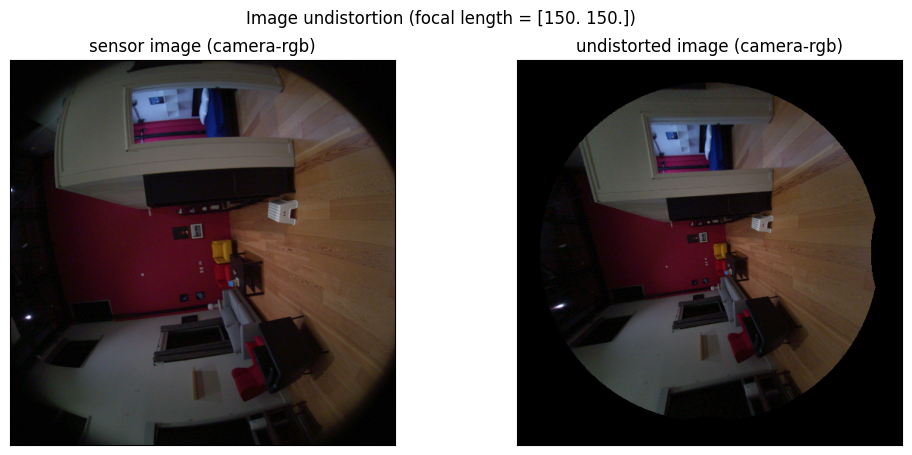

In [17]:
# input: retrieve image as a numpy array
sensor_name = "camera-rgb"
sensor_stream_id = provider.get_stream_id_from_label(sensor_name)
image_data = provider.get_image_data_by_index(sensor_stream_id, 0)
image_array = image_data[0].to_numpy_array()
# input: retrieve image distortion
device_calib = provider.get_device_calibration()
src_calib = device_calib.get_camera_calib(sensor_name)

# create output calibration: a linear model of image size 512x512 and focal length 150
# Invisible pixels are shown as black.
dst_calib = calibration.get_linear_camera_calibration(512, 512, 150, camera_name)

# distort image
rectified_array = calibration.distort_by_calibration(image_array, dst_calib, src_calib)

# visualize input and results
plt.figure()
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(f"Image undistortion (focal length = {dst_calib.get_focal_lengths()})")

axes[0].imshow(image_array, cmap="gray", vmin=0, vmax=255)
axes[0].title.set_text(f"sensor image ({sensor_name})")
axes[0].tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
axes[1].imshow(rectified_array, cmap="gray", vmin=0, vmax=255)
axes[1].title.set_text(f"undistorted image ({sensor_name})")
axes[1].tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
plt.show()

Note the rectified image shows a circular area of visible pixels. If you want the entire rectified image to be covered by pixels, you can increase the magnification.